<h1> Lecture 12: Fit of Binned Distributions </h1>

In the case of few counts present in the bins,

Bins with zero counts do not contribute to the fit in the case of least squares, despite the absence of events being important information

It is recommended to use the maximum likelihood method

In the case of many counts present in the bins, the two methods are equivalent, and often the least squares method is computationally simpler

<h3> 12.2.3. Defining the statistical model for the fit </h3>
The minimization performed by the fit is based on the comparison between the number of events observed in each bin with respect to the expectation

This expectation is calculated by integrating the model probability density function

Therefore, the input model iminuit needs to be provided with is based on cumulative distribution functions

In [4]:
import iminuit 

def mod_total (bin_edges, N_signal, mu, sigma, N_background, tau):
    return N_signal * norm.cdf (bin_edges, mu, sigma) + \
            N_background * expon.cdf (bin_edges, 0, tau )

The edges of the input histogram are a necessary input for the probability calculations

<h3> Exercise 12.1</h3>

<p> Write a program that fits the events saved in the file dati.txt. </p>
<ul> 
<li> Take care to determine the range and binning of the histogram used for the fit based on the events themselves, writing appropriate algorithms to determine the minimum and maximum of the sample and a reasonable estimate of the number of bins to use.

</li>
<li> Determine the initial values of the fit parameters using the techniques described in the lesson.</li>
<li>Print the fit result on the screen. </li>
<li> Plot the histogram with the fitted model overlaid.</li>
<li> Which parameters are correlated, and which are anti-correlated with each other?</li>
</ul>

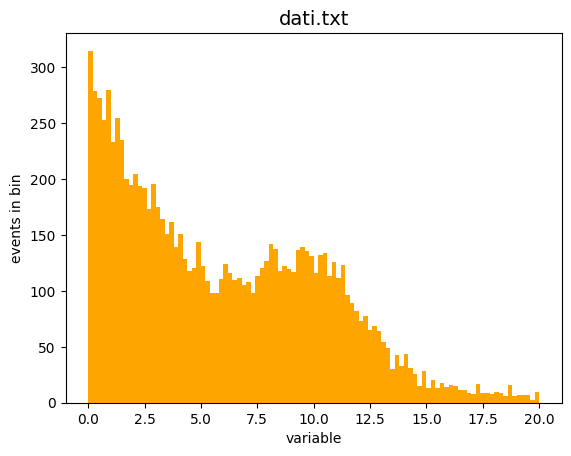

In [19]:
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt




file = open('/Users/giuliodilernia/Documents/Lab-Code-/Ex 12 Python/dati.txt', 'r').read()
sample = file.split("\n")
sample.remove('')
    
values = [float(x) for x in sample]

# show its content in a histogram
sample_mean = np.mean (values)
sample_sigma = np.std (values)
# first guess of x_axis range, before looking at the histogram
# x_min = sample_mean - 3 * sample_sigma 
# x_max = sample_mean + 3 * sample_sigma
x_min   = floor (min (values))
x_max   = ceil (max (values))
x_range = (x_min, x_max)
N_bins  = floor (len (values)/100)

# build a numpy histogram containing the data counts in each bin

bin_content, bin_edges = np.histogram (values, bins = N_bins, range = x_range)

fig, ax = plt.subplots ()
ax.set_title ('dati.txt', size=14)
ax.set_xlabel('variable')
ax.set_ylabel('events in bin')
ax.hist (values,
         bins = bin_edges,
         color = 'orange',
        )

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
#this function is the input model for the iminuit library 
#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def mod_total (bin_edges, N_signal, mu, sigma, N_background, tau):
    return N_signal * norm.cdf (bin_edges, mu, sigma) + \
            N_background * expon.cdf (bin_edges, 0, tau )

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

from iminuit import Minuit
from scipy.stats import expon, norm
from iminuit.cost import ExtendedBinnedNLL

N_events = sum (bin_content)

# the cost function for the fit
my_cost_func = ExtendedBinnedNLL (bin_content, bin_edges, mod_total)

# the fitting algoritm
my_minuit = Minuit (my_cost_func, 
                    N_signal = N_events, mu = sample_mean, sigma = sample_sigma, # signal input parameters
                    N_background = N_events, tau = 1.)                          # background input parameters

# bounds the following parameters to being positive
my_minuit.limits['N_signal', 'N_background', 'sigma', 'tau'] = (0, None)

<h2> Fitting with only the background model </h2>

In [17]:
 #fixing the following parameters,
# setting the signal to zero for a first background-only preliminary fit
my_minuit.values["N_signal"] = 0
my_minuit.fixed["N_signal", "mu", "sigma"] = True

# we temporarily mask out the signal
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
my_cost_func.mask = (bin_centres < 5) | (15 < bin_centres)

my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.56 (χ²/ndof = 0.9)      │              Nfcn = 985              │
│ EDM = 2.74e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │     0     │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │  yes  │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │  yes  │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │  yes  │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │       │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │  -0.11e3  │  0.11e3   │   -0.08   │   0.08    │   -0.08   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │            0            0            0            0        0.000 │
│           mu │            0            0            0            0        0.000 │
│        sigma │            0            0            0            0        0.000 │
│ N_background │            0            0            0     1.71e+04        7.192 │
│          tau │        0.000        0.000        0.000        7.192       0.0106 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

<h2> Fitting with only the signal model </h2>

In [18]:
my_cost_func.mask = None # remove mask
my_minuit.fixed = False # release all parameters
my_minuit.fixed["N_background", "tau"] = True # fix background amplitude
my_minuit.values["N_signal"] = N_events - my_minuit.values["N_background"] # do not start at the limit

my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.68 (χ²/ndof = 0.9)      │             Nfcn = 1166              │
│ EDM = 8.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.23e3   │  0.07e3   │  -0.07e3   │   0.07e3   │    0    │         │       │
│ 1 │ mu           │   9.99    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.04    │   0.06    │   -0.06    │    0.07    │    0    │         │       │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │  yes  │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │  yes  │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │    -70    │    70     │   -0.08   │   0.08    │   -0.06   │   0.07    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │      4.9e+03       -1.390        1.744          0e3          0e3 │
│           mu │       -1.390      0.00572       -0.001        0.000        0.000 │
│        sigma │        1.744       -0.001      0.00422        0.000        0.000 │
│ N_background │          0e3        0.000        0.000            0            0 │
│          tau │          0e3        0.000        0.000            0            0 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

<h2> Final fit over the full range, with the full model </h2>

In [20]:
my_minuit.fixed = False # release all parameters
my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.78 (χ²/ndof = 0.9)      │              Nfcn = 766              │
│ EDM = 2.9e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.31e3   │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ N_background │  7.85e3   │  0.14e3   │  -0.14e3   │   0.14e3   │    0    │         │       │
│ 4 │ tau          │   5.11    │   0.11    │   -0.11    │    0.11    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │       N_signal        │          mu           │         sigma         │     N_background      │          tau          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.11e3  │  0.11e3   │   -0.08   │   0.08    │   -0.08   │   0.08    │  -0.14e3  │  0.14e3   │   -0.11   │   0.11    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.18e+04       -2.858        5.923     -0.011e6       -8.277 │
│           mu │       -2.858      0.00621       -0.002        3.035        0.001 │
│        sigma │        5.923       -0.002      0.00681       -6.644       -0.005 │
│ N_background │     -0.011e6        3.035       -6.644     2.01e+04       10.025 │
│          tau │       -8.277        0.001       -0.005       10.025       0.0129 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

<h2> The parameter values and uncertainties </h2>

In [14]:
print (my_minuit.params)

┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.31e3   │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ N_background │  7.85e3   │  0.14e3   │  -0.14e3   │   0.14e3   │    0    │         │       │
│ 4 │ tau          │   5.11    │   0.11    │   -0.11    │    0.11    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [15]:
#print (my_minuit.merrors)
for elem in my_minuit.merrors:
    print (elem + ' : + ' + str (my_minuit.merrors[elem].upper) + ' ' + str (my_minuit.merrors[elem].lower))

N_background : + 141.667753937816 -142.3642203027322
tau : + 0.11391045367479741 -0.11325068980706418
N_signal : + 110.42712474617697 -106.9384108257863
mu : + 0.07828723971419758 -0.07937371131270347
sigma : + 0.08437594686477311 -0.08092110116380291


In [16]:
for key in my_minuit.parameters : # parameters is a tuple containing the parameter names
    print ('parameter ' + key + ': ' + 
           str (my_minuit.values[key]) + ' +- ' + 
           str (my_minuit.errors[key]) + '   |   ' +
           str (my_minuit.merrors[key].upper) + ' ' + 
           str (my_minuit.merrors[key].lower)
          )

parameter N_signal: 2308.1512549600866 +- 108.58026070296182   |   110.42712474617697 -106.9384108257863
parameter mu: 9.97394336808489 +- 0.07878641442867508   |   0.07828723971419758 -0.07937371131270347
parameter sigma: 2.0865308511527383 +- 0.08254062204404011   |   0.08437594686477311 -0.08092110116380291
parameter N_background: 7848.772941677266 +- 141.92655922899803   |   141.667753937816 -142.3642203027322
parameter tau: 5.112032035923941 +- 0.11349548919684782   |   0.11391045367479741 -0.11325068980706418


<h2> Covariance matrix of the parameters </h2>

In [21]:
print (my_minuit.covariance)

┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.18e+04       -2.858        5.923     -0.011e6       -8.277 │
│           mu │       -2.858      0.00621       -0.002        3.035        0.001 │
│        sigma │        5.923       -0.002      0.00681       -6.644       -0.005 │
│ N_background │     -0.011e6        3.035       -6.644     2.01e+04       10.025 │
│          tau │       -8.277        0.001       -0.005       10.025       0.0129 │
└──────────────┴──────────────────────────────────────────────────────────────────┘


In [22]:
print (my_minuit.covariance[0][1])
print (my_minuit.covariance['N_signal']['N_background'])

-2.857670202523448
-10691.710217554062


In [23]:
# get the correlation matrix:
print (my_minuit.covariance.correlation ())

┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │            1         -0.3          0.7         -0.7         -0.7 │
│           mu │         -0.3            1         -0.4          0.3          0.1 │
│        sigma │          0.7         -0.4            1         -0.6         -0.5 │
│ N_background │         -0.7          0.3         -0.6            1          0.6 │
│          tau │         -0.7          0.1         -0.5          0.6            1 │
└──────────────┴──────────────────────────────────────────────────────────────────┘
